## Imports

In [12]:
import glob
import itertools
import json
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from mat4py import loadmat
import numpy as np
import os 
import pandas as pd
from pylab import *
import seaborn as sns
import scipy.io 
from tqdm import tqdm
import re
from collections import defaultdict
import sys

from collections import Counter
from scipy.stats import linregress
from scipy.stats import entropy as shannon_entropy
from matplotlib.patheffects import withStroke
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
from collections import defaultdict

# sys.path.append(os.path.join(os.getcwd(), "src"))
from src.utils import *
from src.detect_good_k_mean_alg import *
from src.visualisation_plots import *
from src.tokenize_birdsong import *



## Preparing data
Birdsong annotations are pre-processed to make sure it is compatible with the tokenization

**Your annotations must annotate using a single character per meaningful units**
Here one letter label each phrases. 

In [13]:
hop=512
sr=44100 #sample rate
length_enregis=11935 #length of the activity file

In [14]:
process = 'phrase'
nb_ms = 10 #modif avec hyperopt
aggregated_trials=False
firing_rate= True
nb_trials=1
# Reminescence of old code, to remove and clean process_Y_data()

Change songs_path to your wanted annotation dataset if needed

In [15]:
#forme Y seul
songs_path = "annotation_data/rouge6_annotated/rouge6_dataset_corrected_wo_silence"


Y = process_Y_data( songs_path, process, nb_ms, aggregated_trials, nb_trials)
print(Y)
print(len(Y))

['SIL', 'Z', 'A1', 'B', 'T', 'A2', 'B', 'E1', 'E2', 'S1', 'S2', 'Y', 'U', 'SIL', 'END', 'SIL', 'A1', 'B', 'E1', 'X', 'P1', 'P2', 'S1', 'St', 'S2', 'Y', 'V', 'SIL', 'END', 'SIL', 'A1', 'F', 'SIL', 'T', 'A2', 'B', 'E1', 'E2', 'S1', 'SIL', 'T', 'SIL', 'END', 'SIL', 'Z', 'A2', 'B', 'S1', 'S2', 'Y', 'V', 'E1', 'S1', 'S2', 'Y', 'U', 'SIL', 'END', 'SIL', 'G', 'Z', 'SIL', 'T', 'A2', 'S1', 'S2', 'Y', 'SIL', 'END', 'SIL', 'Z', 'G', 'A1', 'B', 'C', 'T', 'SIL', 'END', 'SIL', 'G', 'T', 'A2', 'B', 'S1', 'S2', 'Y', 'U', 'SIL', 'END', 'SIL', 'Z', 'SIL', 'B', 'T', 'A2', 'B', 'SIL', 'END', 'SIL', 'Ti', 'SIL', 'Z', 'A1', 'B', 'S1', 'St2', 'SIL', 'cri', 'SIL', 'END', 'SIL', 'A1', 'B', 'T', 'A1', 'B', 'SIL', 'END', 'SIL', 'Ti', 'SIL', 'A2', 'B', 'S1', 'S2', 'Y', 'SIL', 'V', 'E1', 'S1', 'St2', 'S1', 'S2', 'Y', 'X', 'P2', 'S1', 'St2', 'S2', 'Y', 'U', 'SIL', 'END', 'SIL', 'Z', 'A1', 'B', 'S1', 'S2', 'Y', 'SIL', 'END', 'SIL', 'Z', 'A1', 'B', 'SIL', 'S1', 'T', 'SIL', 'END', 'SIL', 'Z', 'SIL', 'A1', 'B', 'S1', '

In [16]:

Y_clean = clean_Y(Y)

Y_clean_np = np.array(Y_clean)
consecutives_duplicated = [Y_clean_np[i] == Y_clean_np[i + 1] for i in range(len(Y_clean_np) - 1)]
consecutives_duplicated = consecutives_duplicated.count(True)
print("Number of consecutive duplicates:", consecutives_duplicated)
syllables, counts = np.unique(Y_clean_np, return_counts=True)


Number of consecutive duplicates: 0


# Tokenizer

This is the tokenization process, which find tokens in sequences of labels of length 1

In [17]:
def export_list_to_txt(y, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        line = []
        for item in y:
            if item == 'END':
                f.write(' '.join(line) + '\n')  # Écrit la ligne complète
                line = []  # Réinitialise la liste pour une nouvelle ligne
            else:
                line.append(str(item))  # Ajoute l'élément à la ligne

output_file = 'data_rouge6.txt'



In [18]:
syll = tokenize_syllables(pd.Series(Y), 36, "BPE")

In [19]:
from collections import Counter
import pandas as pd
import numpy as np


df_Y = pd.Series(Y)
count_syllabes = df_Y.nunique()
print(count_syllabes)
results = []




tokenizer_type = "WordPiece"  
results_df, new_token_occurrence_df, chunks , chunks_vocab_33 = analyze_vocab_sizes(tokenize_syllables, df_Y, 
                                                          range(count_syllabes, 4*count_syllabes), tokenizer_type=tokenizer_type)

# # Remplacer les '#' dans les tokens et supprimer ceux dont la longueur est inférieure à 2

new_token_occurrence_df['token'] = new_token_occurrence_df['token'].apply(lambda tok: tok.replace('#', '') 
                                                                          if isinstance(tok, str) else tok)
tokens_to_drop = new_token_occurrence_df[new_token_occurrence_df['token'].str.len() < 2].index
new_token_occurrence_df.drop(tokens_to_drop, inplace=True)

print(results_df.head())
print(count_syllabes, count_syllabes*4)

25
token_counts.values(): dict_values([])
token_probs: []
mean token probs : nan
vocab_size=25 | mean_length=1.00 | nb_chunks=467
token_counts.values(): dict_values([])
token_probs: []
mean token probs : nan
vocab_size=26 | mean_length=1.00 | nb_chunks=467
token_counts.values(): dict_values([])
token_probs: []
mean token probs : nan
vocab_size=27 | mean_length=1.00 | nb_chunks=467
token_counts.values(): dict_values([])
token_probs: []
mean token probs : nan
vocab_size=28 | mean_length=1.00 | nb_chunks=467
token_counts.values(): dict_values([])
token_probs: []
mean token probs : nan
vocab_size=29 | mean_length=1.00 | nb_chunks=467


c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Users\axela\miniconda3\envs\bird_tokenization\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\axela\miniconda3\envs\bird_tokenization\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Users\axela\miniconda3\envs\bird_tokenization\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\axela\miniconda3\envs\bird_tokenization\Lib\site-

token_counts.values(): dict_values([])
token_probs: []
mean token probs : nan
vocab_size=30 | mean_length=1.00 | nb_chunks=467
token_counts.values(): dict_values([])
token_probs: []
mean token probs : nan
vocab_size=31 | mean_length=1.00 | nb_chunks=467
token_counts.values(): dict_values([])
token_probs: []
mean token probs : nan
vocab_size=32 | mean_length=1.00 | nb_chunks=467
token_counts.values(): dict_values([])
token_probs: []
mean token probs : nan
vocab_size=33 | mean_length=1.00 | nb_chunks=467
token_counts.values(): dict_values([])
token_probs: []
mean token probs : nan
vocab_size=34 | mean_length=1.00 | nb_chunks=467


c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Users\axela\miniconda3\envs\bird_tokenization\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\axela\miniconda3\envs\bird_tokenization\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Users\axela\miniconda3\envs\bird_tokenization\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\axela\miniconda3\envs\bird_tokenization\Lib\site-

token_counts.values(): dict_values([])
token_probs: []
mean token probs : nan
vocab_size=35 | mean_length=1.00 | nb_chunks=467
token_counts.values(): dict_values([])
token_probs: []
mean token probs : nan
vocab_size=36 | mean_length=1.00 | nb_chunks=467
token_counts.values(): dict_values([62])
token_probs: [1.0]
mean token probs : 1.0
vocab_size=37 | mean_length=1.15 | nb_chunks=405
token_counts.values(): dict_values([62, 58])
token_probs: [0.5166666666666667, 0.48333333333333334]
mean token probs : 0.5
vocab_size=38 | mean_length=1.35 | nb_chunks=347
token_counts.values(): dict_values([62, 58])
token_probs: [0.5166666666666667, 0.48333333333333334]
mean token probs : 0.5
vocab_size=39 | mean_length=1.35 | nb_chunks=347
token_counts.values(): dict_values([30, 32, 58])
token_probs: [0.25, 0.26666666666666666, 0.48333333333333334]
mean token probs : 0.3333333333333333
vocab_size=40 | mean_length=1.47 | nb_chunks=317
token_counts.values(): dict_values([30, 32, 58])
token_probs: [0.25, 0.2

c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: Futur

token_counts.values(): dict_values([30, 32, 21, 37])
token_probs: [0.25, 0.26666666666666666, 0.175, 0.30833333333333335]
mean token probs : 0.25
vocab_size=43 | mean_length=1.58 | nb_chunks=296
token_counts.values(): dict_values([30, 17, 21, 37, 15])
token_probs: [0.25, 0.14166666666666666, 0.175, 0.30833333333333335, 0.125]
mean token probs : 0.2
vocab_size=44 | mean_length=1.67 | nb_chunks=279
token_counts.values(): dict_values([30, 17, 21, 29, 37])
token_probs: [0.22388059701492538, 0.12686567164179105, 0.15671641791044777, 0.21641791044776118, 0.27611940298507465]
mean token probs : 0.2
vocab_size=45 | mean_length=1.76 | nb_chunks=265
token_counts.values(): dict_values([30, 17, 21, 29, 37, 12])
token_probs: [0.2054794520547945, 0.11643835616438356, 0.14383561643835616, 0.19863013698630136, 0.2534246575342466, 0.0821917808219178]
mean token probs : 0.16666666666666666
vocab_size=46 | mean_length=1.85 | nb_chunks=253
token_counts.values(): dict_values([30, 17, 21, 29, 26, 11, 1])
to

c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: Futur

token_counts.values(): dict_values([11, 25, 14, 21, 18, 8, 12, 5, 7, 7])
token_probs: [0.0859375, 0.1953125, 0.109375, 0.1640625, 0.140625, 0.0625, 0.09375, 0.0390625, 0.0546875, 0.0546875]
mean token probs : 0.1
vocab_size=52 | mean_length=2.21 | nb_chunks=211
token_counts.values(): dict_values([11, 6, 14, 21, 18, 8, 12, 5, 19, 7, 7])
token_probs: [0.0859375, 0.046875, 0.109375, 0.1640625, 0.140625, 0.0625, 0.09375, 0.0390625, 0.1484375, 0.0546875, 0.0546875]
mean token probs : 0.09090909090909091
vocab_size=53 | mean_length=2.28 | nb_chunks=205
token_counts.values(): dict_values([11, 6, 14, 21, 18, 8, 12, 5, 19, 7, 7])
token_probs: [0.0859375, 0.046875, 0.109375, 0.1640625, 0.140625, 0.0625, 0.09375, 0.0390625, 0.1484375, 0.0546875, 0.0546875]
mean token probs : 0.09090909090909091
vocab_size=54 | mean_length=2.28 | nb_chunks=205
token_counts.values(): dict_values([11, 6, 14, 21, 18, 8, 12, 5, 19, 7, 7])
token_probs: [0.0859375, 0.046875, 0.109375, 0.1640625, 0.140625, 0.0625, 0.0937

c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: Futur

token_counts.values(): dict_values([8, 6, 10, 21, 2, 16, 5, 4, 4, 15, 7, 2, 8, 3, 7, 1])
token_probs: [0.06722689075630252, 0.05042016806722689, 0.08403361344537816, 0.17647058823529413, 0.01680672268907563, 0.13445378151260504, 0.04201680672268908, 0.03361344537815126, 0.03361344537815126, 0.12605042016806722, 0.058823529411764705, 0.01680672268907563, 0.06722689075630252, 0.025210084033613446, 0.058823529411764705, 0.008403361344537815]
mean token probs : 0.0625
vocab_size=62 | mean_length=2.54 | nb_chunks=184
token_counts.values(): dict_values([10, 21, 2, 16, 3, 5, 4, 4, 15, 7, 2, 8, 3, 5, 7, 1])
token_probs: [0.08849557522123894, 0.18584070796460178, 0.017699115044247787, 0.1415929203539823, 0.02654867256637168, 0.04424778761061947, 0.035398230088495575, 0.035398230088495575, 0.13274336283185842, 0.061946902654867256, 0.017699115044247787, 0.07079646017699115, 0.02654867256637168, 0.04424778761061947, 0.061946902654867256, 0.008849557522123894]
mean token probs : 0.0625
vocab_size=

c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: Futur

token_counts.values(): dict_values([10, 12, 13, 3, 5, 4, 2, 12, 2, 3, 3, 2, 8, 3, 6, 7, 3, 4, 2, 2])
token_probs: [0.09433962264150944, 0.11320754716981132, 0.12264150943396226, 0.02830188679245283, 0.04716981132075472, 0.03773584905660377, 0.018867924528301886, 0.11320754716981132, 0.018867924528301886, 0.02830188679245283, 0.02830188679245283, 0.018867924528301886, 0.07547169811320754, 0.02830188679245283, 0.05660377358490566, 0.0660377358490566, 0.02830188679245283, 0.03773584905660377, 0.018867924528301886, 0.018867924528301886]
mean token probs : 0.05
vocab_size=71 | mean_length=2.83 | nb_chunks=165
token_counts.values(): dict_values([10, 12, 13, 3, 5, 4, 2, 12, 2, 3, 3, 2, 8, 3, 6, 7, 3, 4, 2, 2, 2])
token_probs: [0.09259259259259259, 0.1111111111111111, 0.12037037037037036, 0.027777777777777776, 0.046296296296296294, 0.037037037037037035, 0.018518518518518517, 0.1111111111111111, 0.018518518518518517, 0.027777777777777776, 0.027777777777777776, 0.018518518518518517, 0.0740740740

c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: Futur

token_counts.values(): dict_values([8, 5, 7, 1, 2, 4, 2, 6, 2, 3, 2, 8, 3, 2, 6, 7, 3, 4, 3, 2, 4, 2, 3, 1, 2])
token_probs: [0.08695652173913043, 0.05434782608695652, 0.07608695652173914, 0.010869565217391304, 0.021739130434782608, 0.043478260869565216, 0.021739130434782608, 0.06521739130434782, 0.021739130434782608, 0.03260869565217391, 0.021739130434782608, 0.08695652173913043, 0.03260869565217391, 0.021739130434782608, 0.06521739130434782, 0.07608695652173914, 0.03260869565217391, 0.043478260869565216, 0.03260869565217391, 0.021739130434782608, 0.043478260869565216, 0.021739130434782608, 0.03260869565217391, 0.010869565217391304, 0.021739130434782608]
mean token probs : 0.039999999999999994
vocab_size=80 | mean_length=3.03 | nb_chunks=154
token_counts.values(): dict_values([7, 5, 5, 1, 2, 4, 2, 6, 2, 3, 2, 8, 3, 2, 6, 7, 3, 4, 3, 2, 4, 2, 3, 1, 2])
token_probs: [0.07865168539325842, 0.056179775280898875, 0.056179775280898875, 0.011235955056179775, 0.02247191011235955, 0.04494382022

c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: Futur

token_counts.values(): dict_values([7, 3, 5, 1, 1, 2, 1, 4, 6, 2, 3, 2, 8, 1, 2, 6, 7, 3, 4, 2, 2, 4, 2, 3, 1, 1, 2, 1])
token_probs: [0.08139534883720931, 0.03488372093023256, 0.05813953488372093, 0.011627906976744186, 0.011627906976744186, 0.023255813953488372, 0.011627906976744186, 0.046511627906976744, 0.06976744186046512, 0.023255813953488372, 0.03488372093023256, 0.023255813953488372, 0.09302325581395349, 0.011627906976744186, 0.023255813953488372, 0.06976744186046512, 0.08139534883720931, 0.03488372093023256, 0.046511627906976744, 0.023255813953488372, 0.023255813953488372, 0.046511627906976744, 0.023255813953488372, 0.03488372093023256, 0.011627906976744186, 0.011627906976744186, 0.023255813953488372, 0.011627906976744186]
mean token probs : 0.03571428571428571
vocab_size=89 | mean_length=3.29 | nb_chunks=142
token_counts.values(): dict_values([7, 3, 5, 1, 1, 2, 1, 4, 1, 6, 2, 3, 2, 8, 1, 2, 6, 7, 3, 4, 2, 2, 4, 2, 3, 1, 1, 2, 1])
token_probs: [0.08045977011494253, 0.0344827586

c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)
c:\Projets\birdsong_tokenizer\src\tokenize_birdsong.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chunks = chunks.applymap(clean_token_list)


# Plot pConv / pDiv

This plot aim to :
* Show the transition probabilites of each transitions (A->B) and transitions sequences (A->B->C so A->B & B->C)
* Find clusters in the distribution
* Compare transitions sequences (ie chunks or tokens) and highlight common sequences

Analyse des probabilités de transition...
Nombre total d'éléments dans la séquence: 598
Nombre de couples de caractères analysés: 45

Premiers résultats:
couple char_a char_b  order    p_div   p_conv  transition_count  total_a  total_b
   F-E      F      E      1 0.500000 0.068966                 2        4       29
   F-S      F      S      1 0.250000 0.013514                 1        4       74
   F-T      F      T      1 0.250000 0.023810                 1        4       42
   Y-X      Y      X      1 0.067797 0.571429                 4       59        7
   Y-E      Y      E      1 0.033898 0.068966                 2       59       29
   Y-U      Y      U      1 0.355932 1.000000                21       59       21
   Y-V      Y      V      1 0.203390 0.857143                12       59       14
   Y-P      Y      P      1 0.033898 0.250000                 2       59        8
   B-E      B      E      1 0.129870 0.344828                10       77       29
   B-S      B      S      

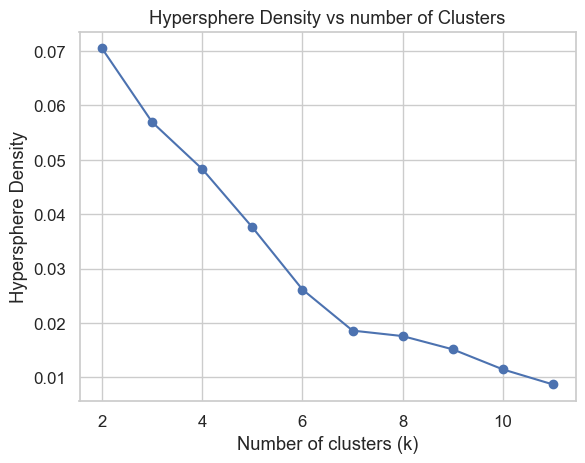

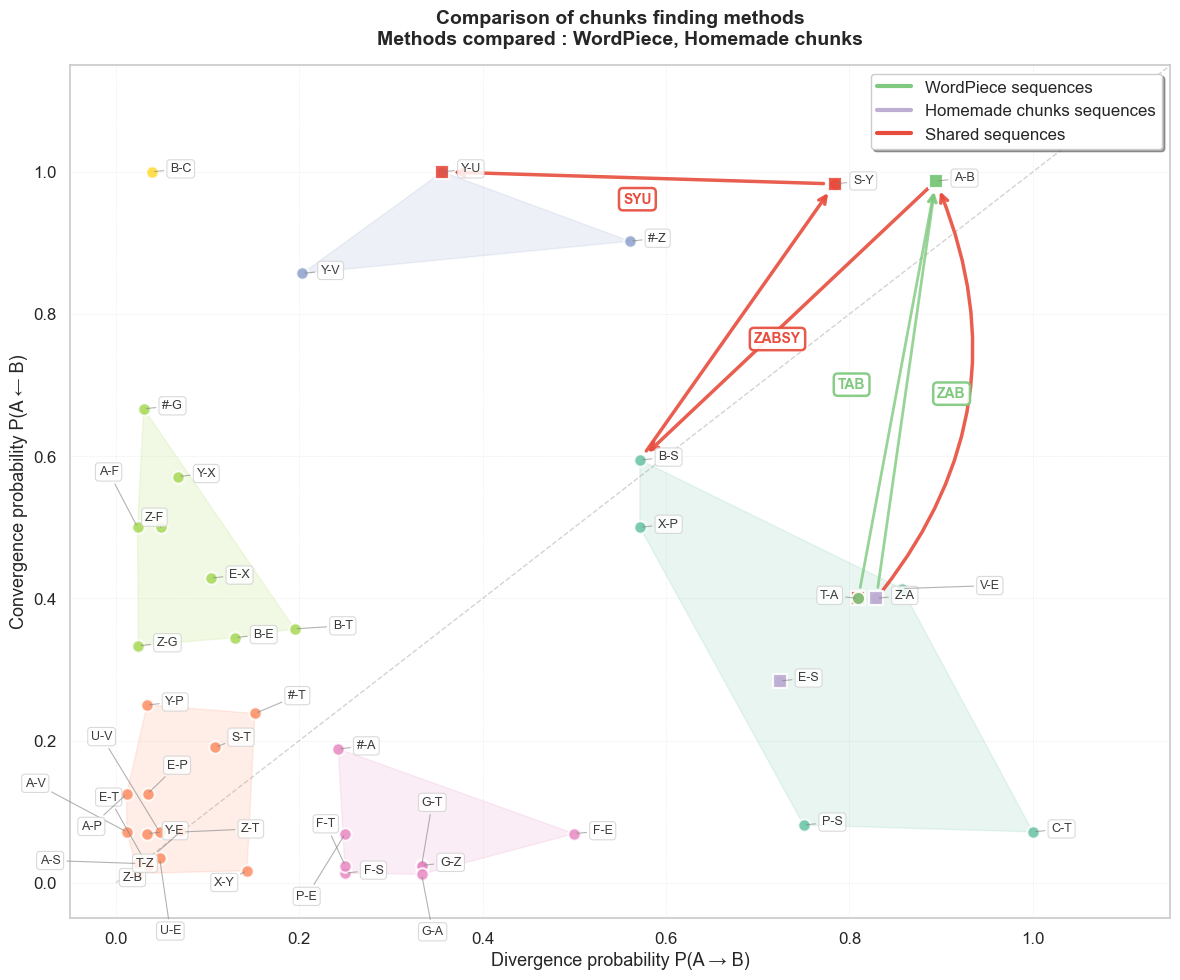

In [20]:
Y_min_test = ['A', 'B', 'A', 'B', 'D', 'Z']





    



#  best_results_BPE : vocab = 41 :
best_BPE = ["TAB", "SY", "AB", "SYU", "ZAB", "ZABSYU", "TABE", "SYVE", "ZABSY", "XP", "ZABS"] # Je coupe à occurence > 5% des chants 
# (ce qui n'est pas vrai à proprement parler car par exemple SY se retrouve dans SY SYU ZABSY ... 
# qui sont tous comptés séparément) juste pour avoir un affichage plus propre
# best results WordPiece
best_WordPiece = ["AB", "SY", "TAB", "SYU", "ZABSY", "ZAB", "SYVE", "ZABSYU", "TABE", "ST", "TABSYU", "TA"]
# best results WordPiece %chants > 30 %
best_WordPiece_30pct = ["AB", "SY", "ZAB", "TA", "TAB", "SYU", "ZABSY"]
# best results Unigram
best_Unigram = ["SYU", "ZABSY", "ZABSYU", "ES", "TA", "ABSY", "TAB", "VES", "ZABTA", "TABTAB", "XP"]
df_results = analyze_sequence_probabilities(Y_clean, order=1, path_groups={"WordPiece": best_WordPiece_30pct, "Homemade chunks": ["SY", "ZA", "TA", "ES", "SYU", "ZABSY"]}, seuil=0.05, verbose=True)

# Long Chunks valides à ordre<=3 pour BPE : 
# ["ZABSYU", "SYXP", "ABSYVE", "TABSYU", "SYVES" ]
# Longs Chunks valides à ordre<=3 pour WordPiece :
# ["ZABSYU", "SYVE", "TABE"]
# Long Chunks valides à ordre<=4 pour Unigram :
# Pour sauvegarder les résultats
# df_results.to_csv('probabilities_results.csv', index=False)

# Pour accéder aux données pour d'autres analyses
# print("Couples avec forte divergence:")
# print(df_results.nlargest(5, 'p_div')[['couple', 'p_div', 'p_conv']])

# print("Couples avec forte convergence:")
# print(df_results.nlargest(5, 'p_conv')[['couple', 'p_div', 'p_conv']])

## Plot pour token presence in songs

Voir utils.py pour les petites fonctions utilisées

Y original: 829 éléments, Y nettoyé: 598 éléments
Nombre total de chants extraits: 65
Nombre de tokens extraits: 119
Tokens uniques: 16

Top 10 tokens par pourcentage de présence dans les chants:
      token  freq  songs_count  percentage
        A B    21           60        92.3
        S Y    16           46        70.8
      Z A B     8           33        50.8
        T A     4           29        44.6
      T A B    15           24        36.9
      S Y U    10           21        32.3
  Z A B S Y     8           20        30.8
        V E     1           11        16.9
    S Y V E     7           10        15.4
Z A B S Y U     7            8        12.3


C:\Users\axela\AppData\Local\Temp\ipykernel_52304\710824939.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=13)


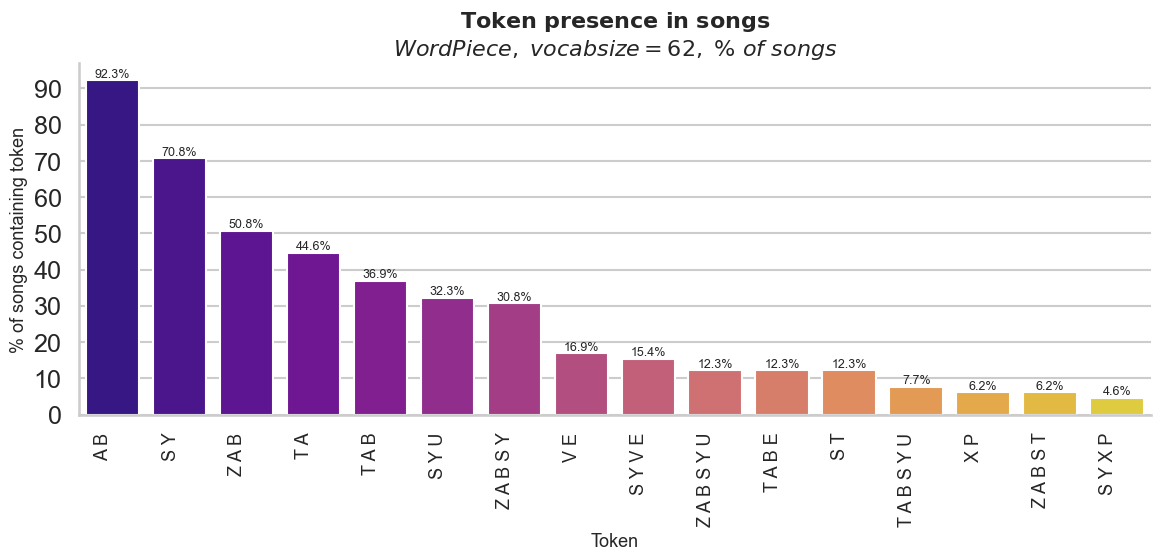


Nombre total de chants analysés: 65


In [21]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import defaultdict
import pandas as pd



vocab_size_plot_most_frequent_chunk = 62
chunks = tokenize_syllables(pd.Series(Y), vocab_size_plot_most_frequent_chunk, "WordPiece")

Y_cleaned = clean_Y(Y)
print(f"Y original: {len(Y)} éléments, Y nettoyé: {len(Y_cleaned)} éléments")

songs = extract_songs_from_cleaned_Y(Y_cleaned)
total_songs = len(songs)
print(f"Nombre total de chants extraits: {total_songs}")


flat_tokens = []

for cell in chunks.values.flatten():
    if isinstance(cell, str) and cell != 'None':
        token = cell.replace('#', '').strip()
        token = ' '.join(token.split())  # supprime les doubles espaces internes et débuts/fin
        if 2 <= len(token.split()) <= 6:
            flat_tokens.append(token)

print(f"Nombre de tokens extraits: {len(flat_tokens)}")
print(f"Tokens uniques: {len(Counter(flat_tokens))}")

token_song_counts = calculate_token_song_presence(flat_tokens, songs)

# Regrouper les tokens identiques visuellement 
visually_same = defaultdict(list)

for token in flat_tokens:
    visually_same[token].append(repr(token))  # repr pour révéler les caractères invisibles

# Trouver les clés qui ont plusieurs représentations
for tok, reps in visually_same.items():
    if len(set(reps)) > 1:
        print(f"Token {tok} has multiple internal forms: {set(reps)}")

# compter les fréquences 
counts = Counter(flat_tokens)

data_for_df = []
for token in counts:
    songs_with_token = token_song_counts[token]
    percentage = (songs_with_token / total_songs) * 100
    data_for_df.append({
        'token': token,
        'freq': counts[token],
        'songs_count': songs_with_token,
        'percentage': percentage
    })

df_counts = pd.DataFrame(data_for_df).sort_values('percentage', ascending=False).head(20)
df_counts = df_counts.reset_index(drop=True)

print("\nTop 10 tokens par pourcentage de présence dans les chants:")
print(df_counts[['token', 'freq', 'songs_count', 'percentage']].head(10).to_string(index=False, float_format='%.1f'))

sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)

# # Graphique 1: Fréquences totales
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
# df_freq = df_counts.sort_values('freq', ascending=False).head(10)
# sns.barplot(data=df_freq, x='token', y='freq', palette="viridis", hue='token', ax=ax1)
# ax1.set_title(r"$\bf{Most\ frequent\ tokens}$" + "\n" + r"$\it{BPE, \ vocab size=47,\ total\ occurrences}$", fontsize=16)
# ax1.set_xlabel("Token", fontsize=13)
# ax1.set_ylabel("Total occurrences", fontsize=13)
# ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="right", fontsize=11)

# for p in ax1.patches:
#     height = p.get_height()
#     ax1.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
#                 ha='center', va='bottom', fontsize=9)

# ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.figure(figsize=(12, 6))

# Graphique: Pourcentages de présence dans les chants
df_perc = df_counts.sort_values('percentage', ascending=False)#.head(10)
ax = sns.barplot(data=df_perc, x='token', y='percentage', palette="plasma", hue='token')
ax.set_title(r"$\bf{Token\ presence\ in\ songs}$" + "\n" + r"$\it{WordPiece, \ vocab size=62,\ \%\ of\ songs}$", fontsize=16)
ax.set_xlabel("Token", fontsize=13)
ax.set_ylabel("% of songs containing token", fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=13)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)

ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

sns.despine()
plt.tight_layout()
plt.show()

print(f"\nNombre total de chants analysés: {total_songs}")

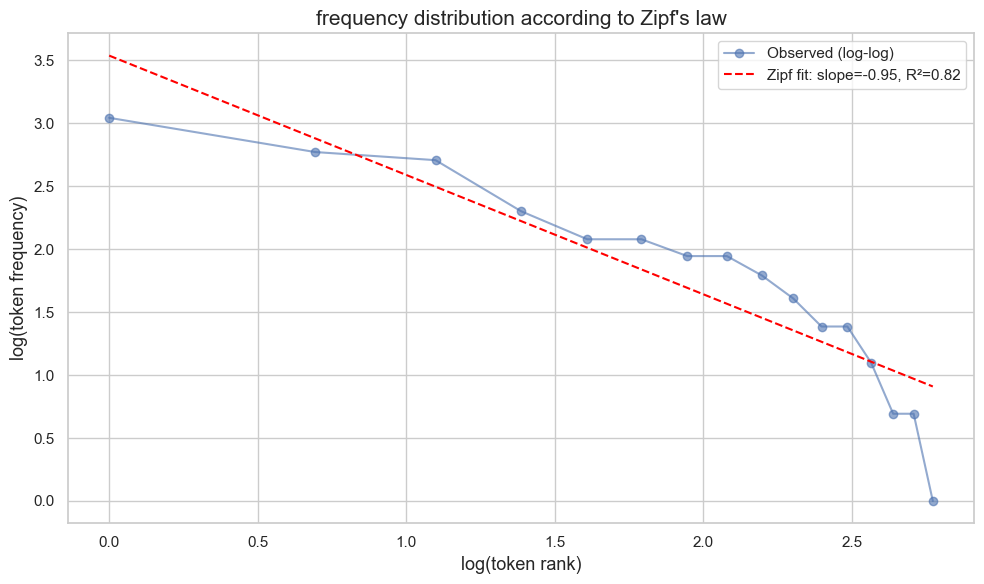

In [22]:


################ ZIPF law plot ################################

counts = Counter(flat_tokens)
freqs = np.array(sorted(counts.values(), reverse=True))
ranks = np.arange(1, len(freqs) + 1)

log_ranks = np.log(ranks)

log_freqs = np.log(freqs)

slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_freqs)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

plt.plot(log_ranks, log_freqs, label="Observed (log-log)", marker='o', alpha=0.6)
plt.plot(log_ranks, intercept + slope * log_ranks, color='red', linestyle='--',
         label=f"Zipf fit: slope={slope:.2f}, R²={r_value**2:.2f}")

plt.title("frequency distribution according to Zipf's law", fontsize=15)
plt.xlabel("log(token rank)", fontsize=13)
plt.ylabel("log(token frequency)", fontsize=13)
plt.legend()
plt.tight_layout()
plt.show()




## Analyse des métriques pour décider du vocabulary size à choisir

Voir fonctions dans visualisation_plots.py

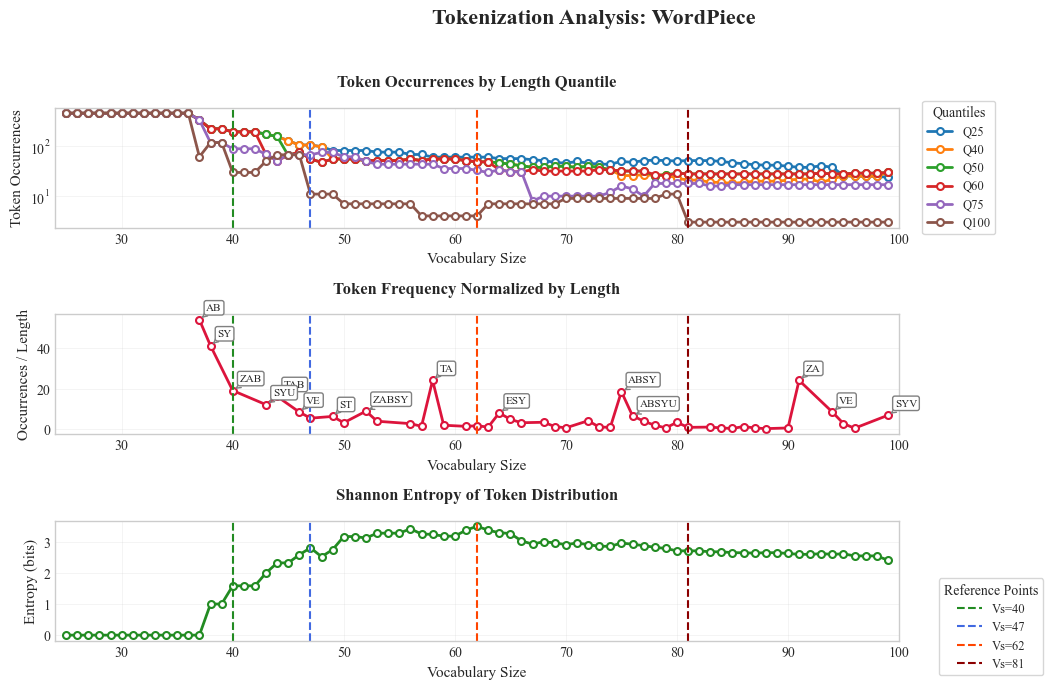

In [23]:
plot_tokenization_analysis(results_df, new_token_occurrence_df, tokenizer_type="WordPiece")


## Plot de la proportion de "vrais" chunks trouvés par les 3 tokenizers

voir fonctions dans visualisation_plot.py


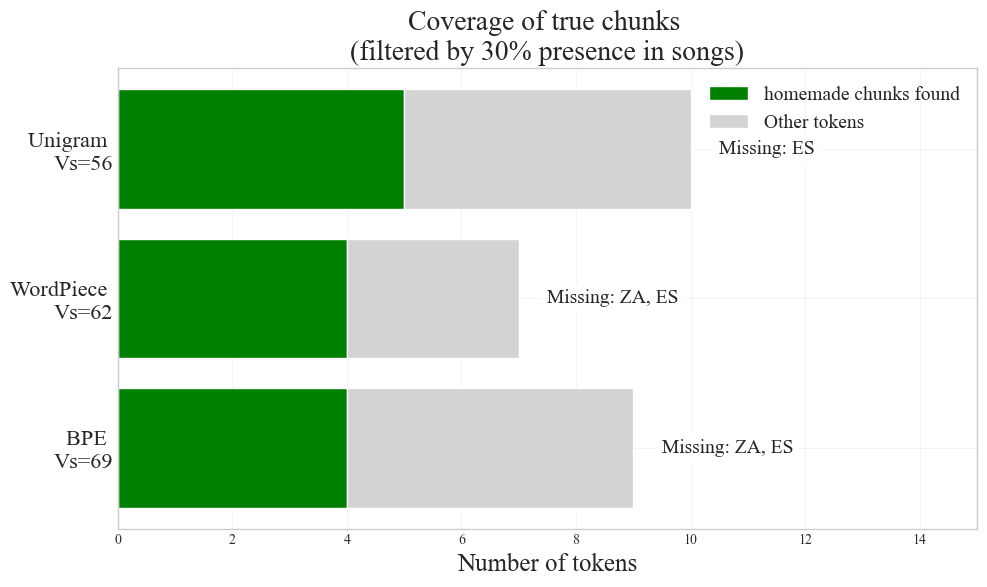

In [27]:

chunks_WordPiece = tokenize_syllables(pd.Series(Y), vocab_size=62, tokenizer_type="WordPiece")
unique_chunk_WordPiece = np.unique(np.array(chunks_WordPiece))
chunks_BPE = tokenize_syllables(pd.Series(Y), vocab_size=69, tokenizer_type="BPE")
unique_chunk_BPE = np.unique(np.array(chunks_BPE))
chunks_Unigram = tokenize_syllables(pd.Series(Y), vocab_size=56, tokenizer_type="Unigram")
unique_chunk_Unigram = np.unique(np.array(chunks_Unigram))
list_true_chunks = ["SY", "ZA", "TA", "ES", "SYU", "ZABSY"]



plot_chunk_distribution_filtered(unique_chunk_BPE, unique_chunk_WordPiece, unique_chunk_Unigram, 
                               list_true_chunks, Y_clean, min_percentage=30, horizontal=True)

### Plot pour décider de quels quantiles garder

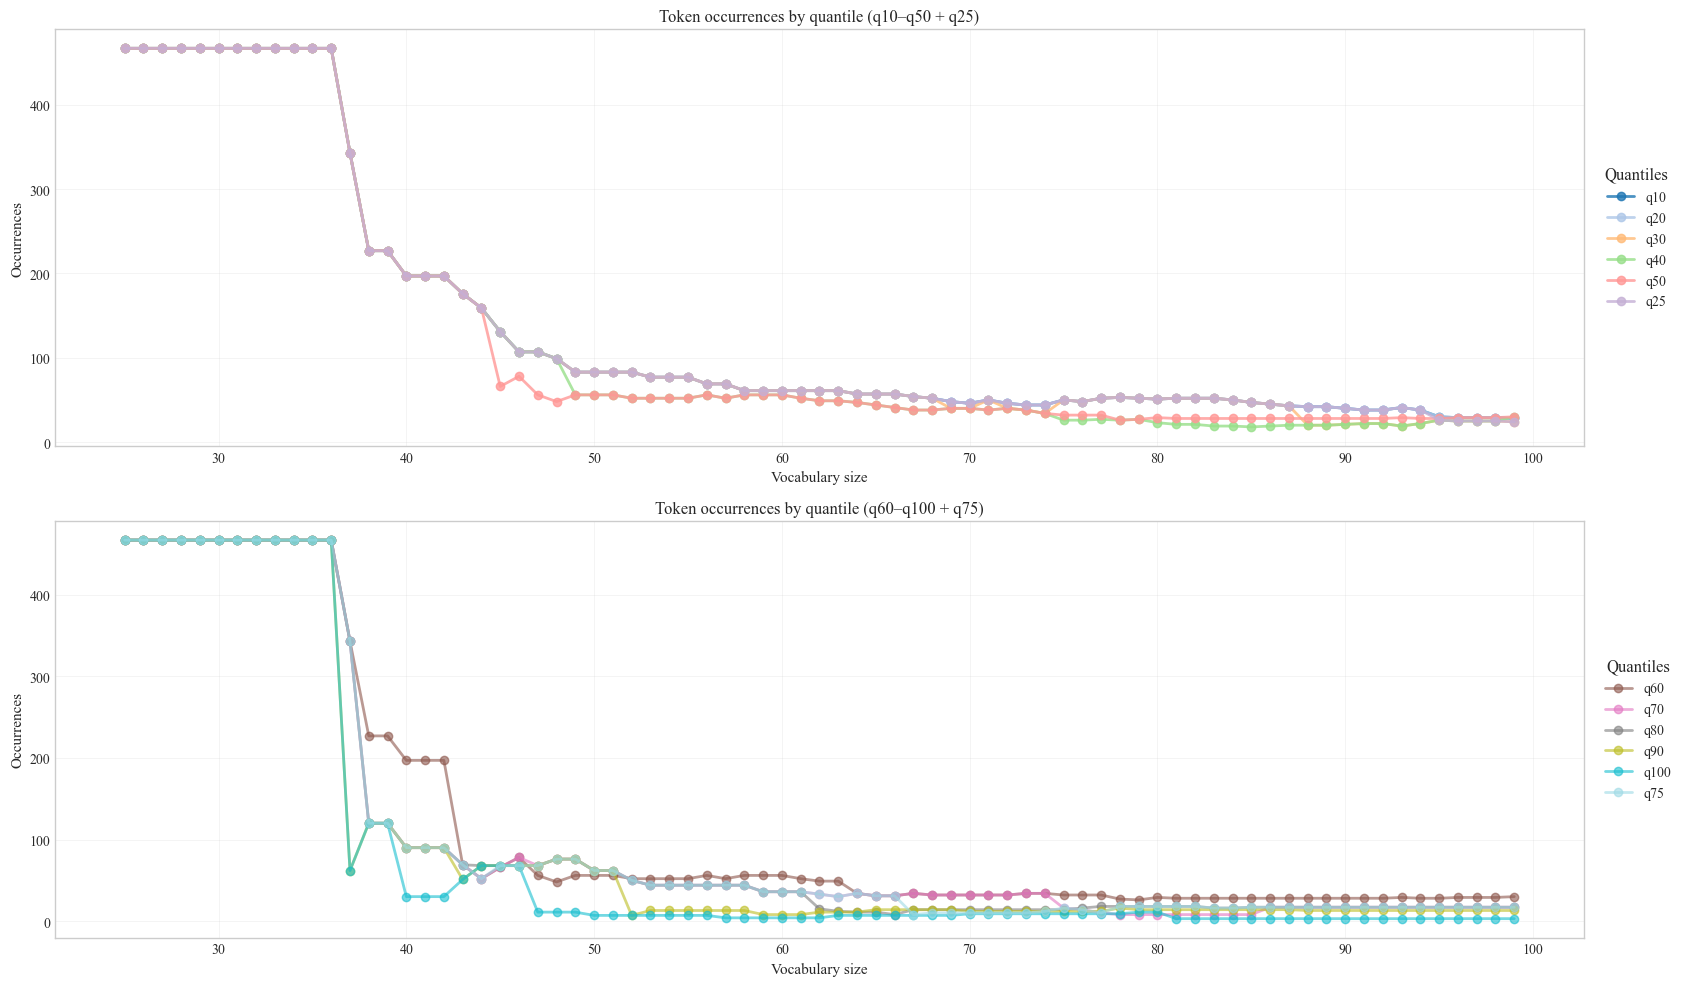

In [26]:
import matplotlib.pyplot as plt
import numpy as np

quantile_list = list(range(10, 101, 10)) + [25, 75]
colors = plt.cm.tab20(np.linspace(0, 1, len(quantile_list)))

# Séparation en 2 groupes de quantiles
first_half = [q for q in quantile_list if q <= 50 or q == 25]
second_half = [q for q in quantile_list if q >= 60 or q == 75]

plt.figure(figsize=(20, 10))

# === SUBPLOT 1 : q10 à q50 + q25 ===
plt.subplot(2, 1, 1)
for q, color in zip(first_half, colors[:len(first_half)]):
    col_name = f'q{q}_occurrences'
    if col_name in results_df.columns:
        plt.plot(
            results_df['vocab_size'],
            results_df[col_name],
            label=f'q{q}',
            color=color,
            marker='o',
            linewidth=2,
            alpha=0.8
        )



plt.title('Token occurrences by quantile (q10–q50 + q25)')
plt.xlabel('Vocabulary size')
plt.ylabel('Occurrences')
# plt.xlim(x_min, x_max)
plt.legend(
    title="Quantiles",
    fontsize=10,
    title_fontsize=12,
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    borderaxespad=0.
)

# === SUBPLOT 2 : q60 à q100 + q75 ===
plt.subplot(2, 1, 2)
for q, color in zip(second_half, colors[len(first_half):]):
    col_name = f'q{q}_occurrences'
    if col_name in results_df.columns:
        plt.plot(
            results_df['vocab_size'],
            results_df[col_name],
            label=f'q{q}',
            color=color,
            marker='o',
            linewidth=2,
            alpha=0.6
        )


plt.title('Token occurrences by quantile (q60–q100 + q75)')
plt.xlabel('Vocabulary size')
plt.ylabel('Occurrences')
# plt.xlim(x_min, x_max)
plt.legend(
    title="Quantiles",
    fontsize=10,
    title_fontsize=12,
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    borderaxespad=0.
)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()
